# I have removed the ABSHID and SF2SA1QN

In [559]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pyecharts.charts import HeatMap
import pyecharts.options as opts
from copy import copy
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import lightgbm
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import kmeans_plusplus
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [568]:
## mytest_data consists of "ABSPID" ,ten response variables and predictor variables (6 confounders + nutritions)
file_name = "mytest_data.csv"
wholedata = pd.read_csv(file_name)
col_y = ["ABSPID", "BMISC", "HCHOLBC", "CHOLRESB", "CHOLNTR", "HDLCHREB", "LDLNTR",
                "LDLRESB", "DIASTOL", "SYSTOL", "HSUGBC"]
confounders = ["ADTOTSE", "SMKSTAT", "AGEC", "EXLWTBC", "SEX", "DIAHBRSK"]
data_conf =wholedata[confounders]
data_y = wholedata[col_y]
data_x = wholedata.iloc[:,17:206] #Nutrition Data


# Dimensional reduction and feature selection


## High Correlation Filter

In [569]:
class cal_corr:
    def __init__(self, df, n_clusters, threshold):
        self.df = self.handle_df(df.copy())
        self.n_clusters = n_clusters
        self.threshold = threshold

        self.corr = None
        

    def corr_matrix(self):

        return self.corr
    

    def corr_pairs(self):

        return self.pairs
        
        
    def handle_df(self,df):

        
        for item in df.select_dtypes(include=["object"]):
            df[item] = df[item].astype('category').cat.codes
        
        df = df.fillna(df.median())
        df = pd.DataFrame(StandardScaler().fit_transform(df),columns=df.columns)
        print(df.shape)
        return df
        
    def order_by_kmeans(self):

        kk = KMeans(n_clusters = self.n_clusters)
        res = kk.fit_predict(self.df.T)
        
        self.df = self.df.append(pd.Series(res,index=self.df.columns),ignore_index=True)
        self.df.sort_values(by = self.df.shape[0]-1,axis=1,inplace=True)
        self.df.drop(self.df.shape[0]-1,inplace=True)
        
        print(self.df.shape)
        
    def corr_heat_map(self):

        self.order_by_kmeans()
        
        self.corr = self.df.corr(method="pearson")
        self.corr = self.corr.round(3)
        self.corr = self.corr.apply(lambda x: abs(x))
        myvalues = []
        for i in range(len(self.corr.index)):
            for j in range(len(self.corr.index)):
                tmp = [i, j, self.corr.iloc[i, j]]
                myvalues.append(copy(tmp))
        self.__setattr__('pairs',myvalues)        
        
        heat_map = HeatMap(init_opts=opts.InitOpts(width="1440px", height="1440px"))\
            .add_xaxis(list(self.corr.columns))\
            .add_yaxis("corr", list(self.corr.index), myvalues) \
            .set_global_opts(
                title_opts=opts.TitleOpts(title="correlation of variables"),
                datazoom_opts=[opts.DataZoomOpts(is_show=True, is_realtime=True), ],
                visualmap_opts=opts.VisualMapOpts(min_=-1.2, max_=1.2, pos_right=20),
                toolbox_opts=opts.ToolboxOpts(is_show=True),
                xaxis_opts=opts.AxisOpts(type_="category", is_scale=True, is_inverse=True, axislabel_opts=opts.LabelOpts(is_show=True, rotate=-60)),
                yaxis_opts=opts.AxisOpts(is_scale=True, is_inverse=False, axislabel_opts=opts.LabelOpts(is_show=True, position="right")),
                tooltip_opts=opts.TooltipOpts(is_show=True))\
            .set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="insideBottom"))

        heat_map.render()
        

    def drop_hight_corr(self):

        
        cor_pair = self.pairs
        cor_pair.sort(key=lambda x:x[2],reverse=True)
        del_pair = []
        del_col = []
        for item in cor_pair:
            if (item[0]==item[1])|(set(item[:2]) in del_pair)|(item[0] in del_col)|(item[1] in del_col):
                continue

            if item[2]>self.threshold:
                c1 = self.corr.iloc[item[0],[x for x in range(self.corr.shape[0]) if x not in del_col]].mean()
                c2 = self.corr.iloc[item[1],[x for x in range(self.corr.shape[0]) if x not in del_col]].mean()

                del_col.append(item[0] if c1>c2 else item[1])
                del_pair.append(set(item[:2]))
            else:
                break
            
        del_col_name = self.corr.iloc[:,del_col].columns
        
        return list(del_col_name)

#  Response variables(y) dataset
if __name__ == '__main__':
    c = cal_corr(df=data_y, n_clusters=5, threshold=0.8)
    c.corr_heat_map()
    del_col = c.drop_hight_corr()
    print(del_col)

(2933, 11)
(2933, 11)
['CHOLRESB', 'LDLRESB']


## PCA 


# Train/Test

In [570]:
categ_y =["HCHOLBC","CHOLNTR", "HDLCHREB", "LDLNTR", "HSUGBC"] # categorical response variables
Conti_y = ["BMISC","DIASTOL", "SYSTOL"] # numeric response variables

In [575]:
col_target = ['HCHOLBC']# can change
y_target = wholedata[col_target]
target = y_target.values
x = data_x = wholedata.iloc[:,11:206]# can change to the new dataset after PCA   pd.concat([new_nutr_data,data_conf],axis=1)
y = wholedata[col_target]
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8)

In [576]:
# Just a test of the LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)
y_predict = log_reg.predict(x_test)
log_reg.score(x_test,y_test)

0.7955706984667802

# Confusion matrix (for categorical response variables)

In [577]:
def plot_ConfusionMatrix(confusionMatrix, response, title=None,  cmap=plt.cm.Blues):
    #labels shows different categories of the response variable
    labels = np.array(data_y[response]).tolist()
    plt.rclabels = np.array(data_y[response]).tolist()
    new_labels=[]
    for i in labels:
        if i not in new_labels:
            new_labels.append(i)
    # Nomalization
    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    str_confusionMatrix = confusionMatrix.astype(np.str).tolist()
    for row in str_confusionMatrix:
        print('\t'.join(row))
    for i in range(confusionMatrix.shape[0]):
        for j in range(confusionMatrix.shape[1]):
            if int(confusionMatrix[i, j]*100 + 0.5) == 0:
                confusionMatrix[i, j]=0
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) 
    ax.set(xticks=np.arange(confusionMatrix.shape[1]),
           yticks=np.arange(confusionMatrix.shape[0]),
           xticklabels=new_labels, yticklabels=new_labels,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')
    # grids
    ax.set_xticks(np.arange(confusionMatrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(confusionMatrix.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = confusionMatrix.max() / 2.
    for i in range(confusionMatrix.shape[0]):
        for j in range(confusionMatrix.shape[1]):
            if int(confusionMatrix[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(confusionMatrix[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if confusionMatrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('ConfusionMatrix of response.jpg', dpi=300)
    plt.show()

0.0	0.013157894736842105	0.0	0.9868421052631579
0.0	0.0	0.0	1.0
0.0	0.0	0.023255813953488372	0.9767441860465116
0.0	0.0	0.0021413276231263384	0.9978586723768736


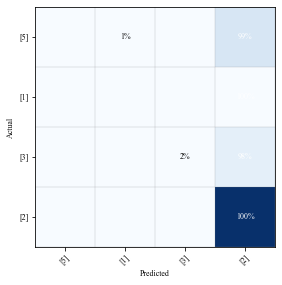

In [578]:
# apply the function to the above LogisticRegression
y_true = y_test
y_pred = y_predict
cm = confusion_matrix(y_true, y_pred)
plot_ConfusionMatrix(cm,response=['HCHOLBC'], title=None,  cmap=plt.cm.Blues)
## show the % of 